In [5]:
import numpy as np
from gp import KernelFunction, GPR
import casadi as cs

nx = 3
ny = 1
kernel = KernelFunction(np.eye(nx),1)
theta0 = np.array([1,1,1])

ns = 2
x_train = np.ones((ns, nx))*10
y_train = np.ones((ns, ny))*7


model = GPR(x_train, y_train, KernelFunction, theta0)


samples = 10

x_sample = np.concatenate([np.arange(0,samples).reshape(-1,1) for i in range(nx)], axis=1)
x_sample_cs = cs.SX.sym('x_sample', samples, nx)

y_predict = model.predict(x_sample)
y_predict_cs = model.predict(x_sample_cs)


f = cs.Function('f',[x_sample_cs],[y_predict_cs])


print(y_predict_cs)
print(f)
print(y_predict)
print(f(x_sample))


Size of feature training data = (2, 3)
Size of output training data = (2, 3)
(2, 10)
(10, 10)
(2, 10)
(10, 10)
@1=2.33333, @2=-0.5, @3=10, [((@1*exp((@2*((sq((@3-x_sample_0))+sq((@3-x_sample_10)))+sq((@3-x_sample_20))))))+(@1*exp((@2*((sq((@3-x_sample_0))+sq((@3-x_sample_10)))+sq((@3-x_sample_20))))))), ((@1*exp((@2*((sq((@3-x_sample_1))+sq((@3-x_sample_11)))+sq((@3-x_sample_21))))))+(@1*exp((@2*((sq((@3-x_sample_1))+sq((@3-x_sample_11)))+sq((@3-x_sample_21))))))), ((@1*exp((@2*((sq((@3-x_sample_2))+sq((@3-x_sample_12)))+sq((@3-x_sample_22))))))+(@1*exp((@2*((sq((@3-x_sample_2))+sq((@3-x_sample_12)))+sq((@3-x_sample_22))))))), ((@1*exp((@2*((sq((@3-x_sample_3))+sq((@3-x_sample_13)))+sq((@3-x_sample_23))))))+(@1*exp((@2*((sq((@3-x_sample_3))+sq((@3-x_sample_13)))+sq((@3-x_sample_23))))))), ((@1*exp((@2*((sq((@3-x_sample_4))+sq((@3-x_sample_14)))+sq((@3-x_sample_24))))))+(@1*exp((@2*((sq((@3-x_sample_4))+sq((@3-x_sample_14)))+sq((@3-x_sample_24))))))), ((@1*exp((@2*((sq((@3-x_sample_5))+

Casadi versus numpy validation of GP

In [6]:
z_train = np.arange(-5,6,1).reshape(-1,1)
y_train = z_train**2


z_query = np.arange(-10,10,0.1).reshape(-1,1)


theta0 = [1,1,1] # Kernel variables
n_sample_function = 5


model_posterior = GPR(z_train, y_train, covariance_function=KernelFunction, theta=theta0)
# ML optimization
model_posterior.fit()
# After optimization
mean_a, cov_a = model_posterior.predict(z_query, cov=True)
std_a = np.diag(cov_a)
y_samples_a = model_posterior.draw_function_sample(z_query, n_sample_function)










Size of feature training data = (11, 1)
Size of output training data = (11, 1)
Maximizing the likelyhood function for GP
Hyperparameters before optimization = [1, 1, 1]
Size of feature training data = (11, 1)
Size of output training data = (11, 1)
Optimization done
Hyperparameters after optimization = [1.46741320e+01 1.17245832e+02 1.00000000e-02]
(11, 200)
(200, 200)
(11, 200)
(200, 200)


/home/ja/Projects/MPC_drone/mpc_quad/gp/gp.py:171: RuntimeWarning: covariance is not positive-semidefinite.
  y_sample = np.random.multivariate_normal(mean=mean_at_values.ravel(), cov=cov_matrix, size=n_sample_functions)


(11, 200)
(200, 200)


In [15]:
z_sample_cs = cs.SX.sym('x_sample', z_query.shape[0], 1)
y_predict_cs = model_posterior.predict(z_sample_cs)

#f_eval_cs = cs.Function('f', [z_sample_cs], [y_predict_cs])
grad_y = cs.jacobian(y_predict_cs, z_sample_cs)

# Symbolic diferentiation
# Create a Function to evaluate expression
f = cs.Function('f',[z_sample_cs],[grad_y])



(11, 200)
(200, 200)


In [19]:
y_cs = f(z_query)
print(y_cs.shape)

(200, 200)


Text(0.5, 1.0, 'Covariance matrix $\\Sigma$')

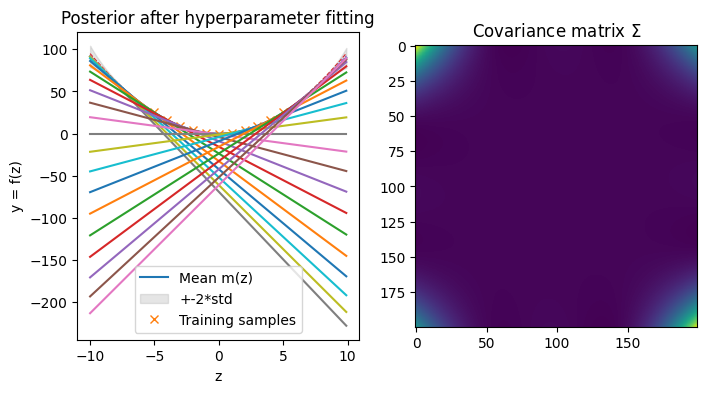

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4), dpi=100)
plt.subplot(1,2,1)
plt.plot(z_query, mean_a)
plt.fill_between(z_query.reshape(-1), mean_a.reshape(-1) - 2*std_a, mean_a.reshape(-1) + 2*std_a, color='gray', alpha=0.2)
plt.plot(z_train, y_train, 'x')
for i in range(y_samples_a.shape[0]):
    plt.plot(z_query, y_samples_a[i],'--', linewidth=0.8)

#plt.plot(z_query, y_cs)

for i in range(0,200,10):
    plt.plot(z_query, y_cs[i,i]*z_query+mean_a[i]- y_cs[i,i]*z_query[i])

#plt.xlim([min(z_query), max(z_query)])
#plt.ylim([min(mean_a), max(mean_a)])
plt.xlabel('z')
plt.ylabel('y = f(z)')
plt.legend(('Mean m(z)', '+-2*std', 'Training samples'))
plt.title('Posterior after hyperparameter fitting')
plt.subplot(1,2,2)
plt.imshow(cov_a)
plt.title('Covariance matrix $\Sigma$')
